# Import libraries and files

In [1]:
import librosa
import random
import librosa.display as lida
from scipy.signal import butter, lfilter
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adadelta
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import scipy.io as spio
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
data_path='/content/drive/MyDrive/Coursework_C/'

In [3]:
# read training data file
mat = spio.loadmat(data_path + 'training.mat', squeeze_me=True)
d = mat['d']
Index = mat['Index']
Class = mat['Class']
Index_sorted=sorted(Index)

In [4]:
# read submition data file
mat = spio.loadmat(data_path + 'submission.mat', squeeze_me=True)
submission = mat['d']

# Functions to make a spectrogram

In [5]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # returns [window_length, num_windows]

In [6]:
def get_STFT(amplitudes, window_length, hop_length):
    # slicing into intersecting frames [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # getting weights for Fourier, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # transforming with Fourier
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

In [7]:
#getting spectrogram
def get_spectrogram(data,index,window,hop):
  stft = get_STFT(data[index-10:index+40],window,hop)
  spectrogram = np.abs(stft ** 2)
  #return(librosa.amplitude_to_db(spectrogram, ref=np.max))
  return(spectrogram)

#normalizing "pixels"
def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return np.array(spec_scaled)

(19, 50)

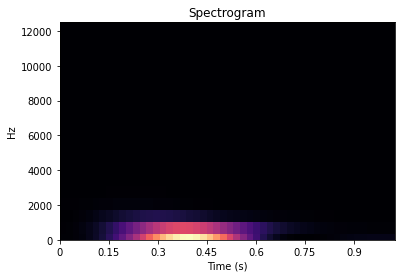

In [8]:
s=get_spectrogram(d,567211,37,1)
lida.specshow(s, sr=25000, x_axis='s', y_axis='hz');
plt.title('Spectrogram')
plt.show
s.shape

(19, 50)

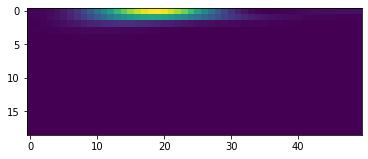

In [9]:
plt.imshow(spec_to_image(s), interpolation='none')
spec_to_image(s).shape

# Filter submission

In [ ]:
def filter_data(data, low=15, high=8000, sf=25000, order=4):
     nyq = sf/2   # Set bands
     low = low/nyq
     high = high/nyq # Calculate coefficients
     b, a = butter(order, [low, high], btype='band')   # Filter signal
     filtered_data = lfilter(b, a, data)
     return filtered_data


In [ ]:
submission_filtered=filter_data(submission)

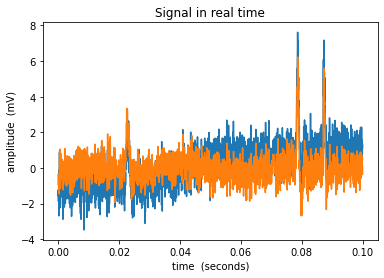

In [ ]:
plt.plot(np.array(range(submission[480000:482500].size))/25000, submission[480000:482500])
plt.title('Signal in real time')
plt.xlabel('time  (seconds)')
plt.ylabel('amplitude  (mV)')
plt.plot(np.array(range(submission_filtered[480000:482500].size))/25000, submission_filtered[480000:482500])
plt.show()

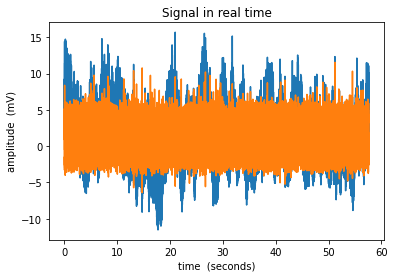

In [ ]:
plt.title('Signal in real time')
plt.xlabel('time  (seconds)')
plt.ylabel('amplitude  (mV)')
plt.plot(np.array(range(submission.size))/25000, submission)
plt.plot(np.array(range(submission_filtered.size))/25000, submission_filtered)
plt.show()

# Identify peaks

Now that we separated the high frequency spike band from the noisy low frequency band we can extract the individual spikes. For this we will write a simple function that does the following:

    1. Find data points in the signal that are above a certain threshold
    2. Define a window around these events and “cut them out”
    3. Align them to their peak amplitude

Additionally we will also define an upper threshold. Data points above this threshold will be rejected as they are likely high frequency artifacts. Such artifacts may arise through movements of the patient or might reflect electrical events like switching on or off a light bulb in the room.

Arguements: 
1.   the filtered data
2.   the number of samples or window which should be extracted from the signal 
3. the threshold factor (mean(signal)*tf) 
4. an offset expressed in number of samples which shifts the maximum peak from the center 
5. the upper threshold which excludes data points above this limit to avoid extracting artifacts.

In [ ]:
def get_spikes(data, spike_window=20, tf=10, offset=0, max_thresh=15):
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data))*tf
    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0] 
    pos = pos[pos > spike_window]
    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]
            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i
                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]
                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)
    return spike_samp, wave_form

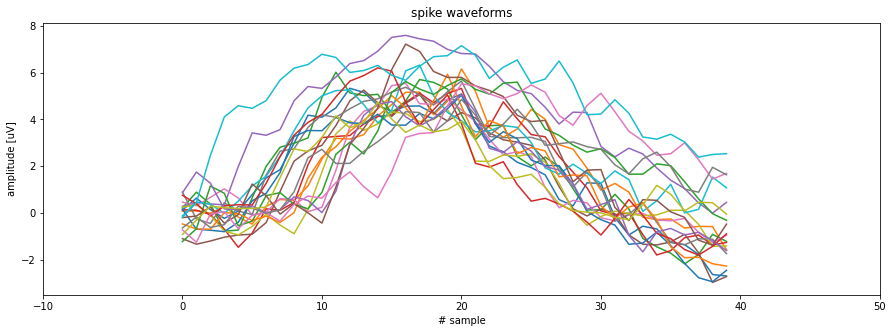

(22299,)
(22300, 40)
11271


In [ ]:
spike_samp, wave_form = get_spikes(submission_filtered, spike_window=20, tf=5)
spike_samp=spike_samp.astype(int)
np.random.seed(42)
fig, ax = plt.subplots(figsize=(15, 5))

for i in range(20):
    spike = np.random.randint(0, wave_form.shape[0])
    ax.plot(wave_form[spike, :])

ax.set_xlim([-10, 50])
ax.set_xlabel('# sample')
ax.set_ylabel('amplitude [uV]')
ax.set_title('spike waveforms')
plt.show()
print((spike_samp).shape)
print((wave_form).shape)
print(spike_samp[222])

In [ ]:
window=37
hop=1
row=19
column=40
spectr_to_predict=[]
# making spectrograms
for spn in spike_samp:
    spec=spec_to_image(get_spectrogram(submission_filtered,spn+10,window,hop))
    spectr_to_predict.append(spec)
spectr_to_predict=np.array(spectr_to_predict)
spectr_to_predict = spectr_to_predict.reshape(spectr_to_predict.shape[0], row, column, 1)
print(spectr_to_predict.shape)

(22299, 19, 40, 1)


(19, 50)

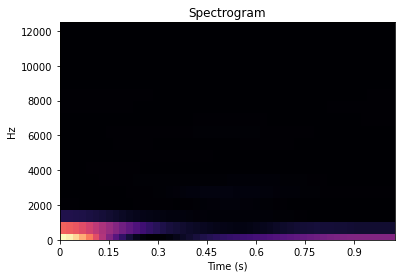

In [ ]:
s=get_spectrogram(submission_filtered,140,37,1)
lida.specshow(s, sr=25000, x_axis='s', y_axis='hz');
plt.title('Spectrogram')
plt.show
s.shape

# Prepaire training and validation data

In [10]:
#arrange Index (starts of activations) and Class in a list of tuples
number_of_activations=len(Index)
keys=[]
for j in range(number_of_activations):
  keys.append((Index[j],Class[j]-1)) # now the classes are named from 0 to 4 rather than from 1 to 5

In [11]:
#shuffle for randomness
random.shuffle(keys)
print(keys)

[(1127419, 4), (1013, 3), (687217, 3), (687039, 1), (643688, 3), (501479, 2), (277206, 0), (1281976, 1), (1309640, 2), (1118776, 0), (1149514, 0), (103613, 3), (200324, 1), (104407, 2), (239265, 4), (1287732, 4), (408045, 0), (440678, 0), (586428, 0), (1085736, 3), (1153272, 2), (67770, 2), (450994, 2), (1099656, 0), (575525, 2), (968239, 3), (819644, 0), (937102, 4), (439198, 3), (584550, 1), (73137, 2), (354708, 0), (886236, 4), (1181528, 1), (209022, 2), (981208, 2), (438142, 4), (310950, 0), (258946, 3), (1291946, 0), (921308, 2), (1051526, 4), (974582, 2), (638162, 0), (1234207, 1), (98377, 3), (507385, 2), (1126100, 4), (333988, 2), (74762, 1), (816373, 1), (1363055, 2), (827313, 2), (624425, 2), (783658, 3), (179843, 4), (762961, 4), (571389, 0), (772790, 4), (138549, 1), (649174, 3), (658822, 1), (1153671, 1), (730676, 4), (84021, 1), (303836, 0), (1328625, 0), (914798, 3), (483259, 4), (531119, 0), (1026999, 2), (1409470, 1), (60719, 2), (1132748, 1), (1017967, 4), (357283, 3)

In [13]:
# short time fourier transform parameters
window=37
hop=1
# future shape of a spectrogram
row=19
column=50
# lists for future training
train_labels=[]
val_labels=[]
train_data=[]
val_data=[]
# spliting parameters for validation and training sets
count=-1
train_set_limit=len(keys)*0.9
val_set_limit=len(keys)
# making spectrograms
for key in keys:
  count+=1
  if val_set_limit>count>train_set_limit:
    val_labels.append(key[1])
    spec=spec_to_image(get_spectrogram(d,key[0],window,hop))
    val_data.append(spec)
  if count<train_set_limit:
    train_labels.append(key[1])
    spec=spec_to_image(get_spectrogram(d,key[0],window,hop))
    train_data.append(spec)
# number of classes
num_category = 5
train_data=np.array(train_data)
val_data=np.array(val_data)
train_data = train_data.reshape(train_data.shape[0], row, column, 1)
val_data = val_data.reshape(val_data.shape[0], row, column, 1)
# convert class vectors to binary class matrices
train_labels = keras.utils.to_categorical(train_labels, num_category)
val_labels = keras.utils.to_categorical(val_labels, num_category)

# Building and compiling the model

    Convolution layer with kernel size : 3x3
    Convolution layer with kernel size : 3x3
    Max Pooling layer with pool size : 2x2
    Dropout layer
    Flattening layer
    2 Dense layered Neural Network at the end

In [14]:
number_of_classes=5
input_shape=(row,column,1)
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPool2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence's sake 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(number_of_classes, activation='softmax'))

In [15]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=Adadelta(),metrics=['accuracy'])

# Training

In [16]:
#model training
model_log = model.fit(train_data, train_labels,
          batch_size=130,
          epochs=200,
          verbose=1,
          validation_data=(val_data, val_labels))

Epoch 1/200
24/24 [==============================] - 12s 44ms/step - loss: 6.6213 - accuracy: 0.1961 - val_loss: 4.5282 - val_accuracy: 0.1826
Epoch 2/200
24/24 [==============================] - 1s 25ms/step - loss: 6.0648 - accuracy: 0.1974 - val_loss: 3.8931 - val_accuracy: 0.1856
Epoch 3/200
24/24 [==============================] - 1s 25ms/step - loss: 5.6704 - accuracy: 0.2160 - val_loss: 3.3578 - val_accuracy: 0.2126
Epoch 4/200
24/24 [==============================] - 1s 26ms/step - loss: 5.4021 - accuracy: 0.2130 - val_loss: 2.9168 - val_accuracy: 0.3144
Epoch 5/200
24/24 [==============================] - 1s 26ms/step - loss: 5.1853 - accuracy: 0.2190 - val_loss: 2.5580 - val_accuracy: 0.3743
Epoch 6/200
24/24 [==============================] - 1s 26ms/step - loss: 4.8832 - accuracy: 0.2230 - val_loss: 2.2735 - val_accuracy: 0.4102
Epoch 7/200
24/24 [==============================] - 1s 25ms/step - loss: 4.5942 - accuracy: 0.2363 - val_loss: 2.0358 - val_accuracy: 0.4162
Epoch

In [ ]:
score = model.evaluate(val_data, val_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

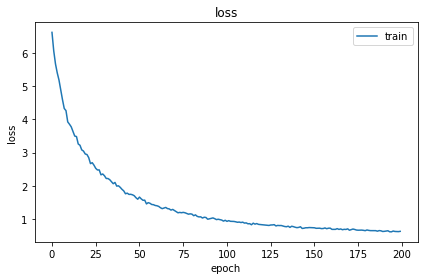

In [17]:
# plotting the metrics
plt.plot(model_log.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

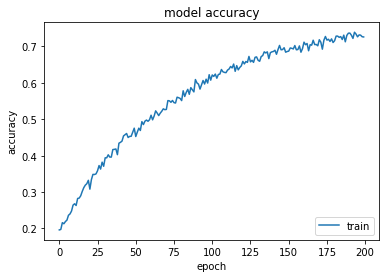

In [19]:
fig = plt.figure()
plt.plot(model_log.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

In [ ]:
#Save the model
model_digit_json = model.to_json()
with open(data_path+'0_model.json', "w") as json_file:
    json_file.write(model_digit_json)
# serialize weights to HDF5
model.save_weights(data_path+'0_model.h5')
print("Saved to disk")

In [ ]:
#loading the model
json_file = open(data_path+'0_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights(data_path+'0_model.h5')
#compiling the model
loaded_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adadelta(),metrics=['accuracy'])

# Feeding data to the neral network

In [ ]:
results=np.array(model.predict(spectr_to_predict))

In [ ]:
results_class=[]
for r in results:
  results_class.append(np.argmax(r)+1)
print(results_class)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 